# SEL 2017/18 - Practical Work 3 - CBR prototype for planning







                                                                                  Alberto Olivares Alarcos

                                                                                  Alejandro Suárez Hernández

## Outline

1. Introduction
    1. Background
    2. Principles of the CBR engine project
    3. Chosen application domain
    
2. Requirement Analysis of the CBR engine Project

3. Functional Architecture of the CBR engine Project

4. Proposed CBR engine Project solution design:
    1. Case Structure and Case Library Structure designed
    2. Methods implementing each CBR cycle step 
    
5. Testing and evaluation

6. Discussion of results

## Introduction

- General purpose planner
    - Arbitrary domains
- Learn from experience
- Code at https://github.com/sprkrd/planning-cbr

The main theme of this project is the design and implementation of a **CBR system for planning**. A CBR based on the use of **several heuristics** has been developed for **general STRIPS-based domain**. We exemplify this report with **three different well known planning domains**. We provide empirical results for these domain at the end of the document.

The whole project is available in Github (https://github.com/sprkrd/planning-cbr).

# Background: STRIPS planning

- Problem described with propositional predicates.
    - E.g. (Hanoi) `{on(disk03, peg1), on(disk02, disk03), on(disk01, disk03), clear(disk01)}`

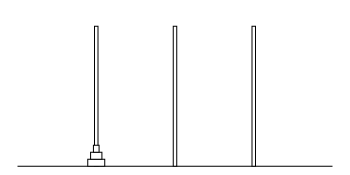

In [12]:
import planning

from IPython.display import display, HTML

domain_name = "Hanoi"
domain = planning.domains[domain_name]
problem = domain.generate_problem(3, 3, random=False)
display(problem.init())

- Domain knowledge
- Problem specific facts

- The domain consists of:
    - Type hierarchy of objects
    - The predicates' "signature"
    - The abstract operators (unground parameters, precondition, effect and cost)
- The specific facts consist of:
    - Objects
    - Initial state
    - Goal condition

## Theoretical principles of planning

We target the problem of planning for arbitrary problems with **STRIPS**-like expressivity. A problem is given by a tuple $(\mathcal{D}, \mathcal{P})$, where $\mathcal{D}$ is the domain and $\mathcal{P}$ is a particular instance of the problem in this domain.

The domain $\mathcal{D}$ represents generic knowledge about the problem. This includes:

* A **type hierarchy** for the problem's objects
* A set of **propositional predicates**
* A set of *actions* or **operators**:
    * A list of optionally typed **parameters** (objects from the world)
    * A **precondition**
    * An **add list**
    * A **delete list**
    * A real positive number that represents the **cost** for this action
    
On the other hand, the instance $\mathcal{P}$ represents the facts of a specific problem. This includes:

* A set of optionally typed **objects** relevant for this problem
* Specification of the **initial state**, as a set of predicates
* Specification of the **goal condition** (it does not have to be a complete state), as a set of predicates

Notice that the **domain is generic** and shared among all the problems of the same type (e.g. the blocks world or the Towers of Hanoi), while the **instance is specific to each problem**. Notice too that, when specifying the domain, the operators are typically **left unground** (i.e. with free variables as parameters), and are **instantiated** for each particular problem.

**STRIPS** adopts the **closed-world assumption**. That is: predicates that are present in the state are true, while predicates that are not are false. That is in **contraposition** to the **open world assumption**, in which predicates that are in the state are marked explicitly as true or false and predicates that are not in the state are unknown.

In this context, planning consists in **finding an applicable sequence of operator that can be executed in chain from the initial state and that result in a state that satisfies the goal condition**. That is, a sequence of operators $o_1, o_2, \dots, o_n$ such that

$$o_1(s_0) \rightarrow s_1$$
$$o_2(s_1) \rightarrow s_2$$
$$\dots $$
$$o_{n}(s_{n-1}) \rightarrow s_n$$
$$s_n \models g$$

In this work, we address this in the most general way possible. That is, we do not make any assumption over the underlying domain.

## Principles of the CBR engine project I

- Heuristic function. Given planning state $s$ and goal $g$:
    - $h(s,g)$ approximates cost of optimum plan from $s$ to $g$
    - Goal often subsumed $h(s,g) = h(s)$
    - Perfect heuristic $h^*(s)$: ~~Approximation of the~~ Optimum plan cost
    - Guides search algorithms (**A\***, IDA\*, ...).

Our aim was to implement a CBR engine which combined several heuristics in order to give a closer estimation of the optimal length of the plan to solve one of our domain's problems. 

The general idea of our work is to use the heuristic calculated by the CBR as the perfect heuristic of any search algorithm used in pathfinding and graph traversal (IDA\*, **A\***, etc.). 

**Case Library Structure**  -  k-d Tree


**Case Structure**  -  Vector of heuristics

## Basic Principles of the CBR engine project II

- CBR: heuristic learning. Better approximator of $h^*(s)$
    - KNN regressor (K-d Tree based)
    - X (input): vector of imperfect heuristics ($h_{add}$, $h_{max}$, $h_{cg}$, $h_{lmcut}$, ...)
    - y (output): $h^*(s)$
- Desired properties:

<img src='report_figures/heuristic_basic_introduction.png'>


A\* guarantees to find the optimal plan if the heuristic is admissible. However, in our approach, we do not look at the absolute value of the heuristic, but at the order that the heuristic induces in the plan states. 

## Chosen application domain I - The tower of Hanoi

<img src='report_figures/hanoi.png'>

The objective of the puzzle is to move the entire stack to another rod, obeying the following simple rules:

1. Only one disk can be moved at a time.
2. Each move consists of taking the upper disk from one of the stacks and placing it on top of another stack.
3. No disk may be placed on top of a smaller disk.

## Chosen application domain I - The tower of Hanoi

- **Single operator**: `move(?what-disk, ?from-object, ?to-object)`
- Entangled subgoals
- Difficult in its most general setting:
    - Arbitrary goal
    - Arbitrary initial state
    - Arbitrary number of disks
    - **Arbitrary number of pegs** $\rightarrow$ branching factor

We have defined the domain in Python and it contains a **single operator**: `move(?what-disk, ?from-object, ?to-object)`, which moves disk `?what` from object `?from` (either a peg or another disk) to object `?to` (also, either a peg or a disk). 

We have implemented static preconditions:

- Not possible to apply operator to move one disk onto a smaller one.
- Not possible to apply operator to move one disk onto itself.

We have also implemented a **problem generator**. The generator can create problems for any number of disks and pegs. 

In [7]:
domain_name = "Hanoi"
domain = planning.domains[domain_name]
problem = domain.generate_problem(3, 3, random=False)
print(domain)

print("Applicable actions in 1st state:")
l = list(filter(problem.init().can_apply, problem.operators()))
print("\n".join(map(str, l)))

Domain: Hanoi
Types: {'peg': 'object', 'disk': 'object'}
Operators:
  - move(?what-disk,?from-object,?to-object):
    Pre: clear(?what), clear(?to), on(?what,?from), smaller(?what,?to)
    Add: clear(?from), on(?what,?to)
    Delete: clear(?to), on(?what,?from)
Applicable actions in 1st state:
move(disk01,disk02,peg2)
move(disk01,disk02,peg3)


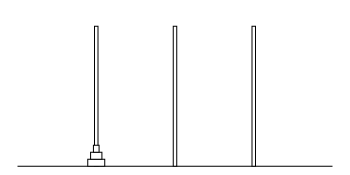

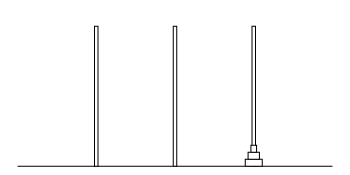

In [15]:
display(HTML("Init:"))
display(problem.init())
display(HTML("Goal:"))
display(problem.goal())

In [16]:
bfs = planning.BreadthFirstSearch(problem, verbose=1, timeout=30.0, node_bound=None)
status = bfs()
if status == planning.search.FOUND:
    plan = bfs.plan()
    state_sequence = bfs.state_sequence()
    print("#Generated nodes: " + str(bfs.info()["generated"]))

    print("Plan:\n  " + "\n  ".join([str(op) for op in bfs.plan()]))

[0.002s] Plan found with 7 action(s)
#Generated nodes: 24
Plan:
  move(disk01,disk02,peg3)
  move(disk02,disk03,peg2)
  move(disk01,peg3,disk02)
  move(disk03,peg1,peg3)
  move(disk01,disk02,peg1)
  move(disk02,peg2,disk03)
  move(disk01,peg1,disk02)


In [5]:
step = 0
plan_lenght = len(state_sequence)

step 0


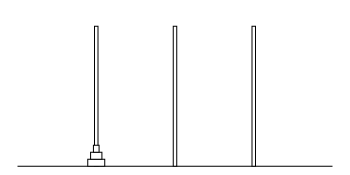

In [6]:
print("step " + str(step))
display(state_sequence[step])
step += 1

step 1


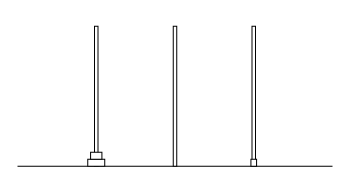

In [7]:
print("step " + str(step))
display(state_sequence[step])
step += 1

step 2


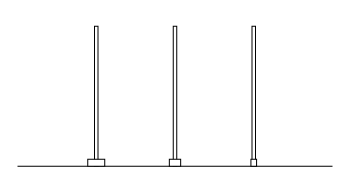

In [8]:
print("step " + str(step))
display(state_sequence[step])
step += 1

step 3


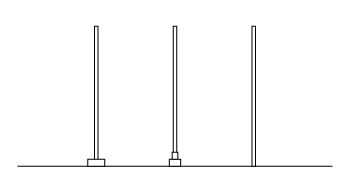

In [9]:
print("step " + str(step))
display(state_sequence[step])
step += 1

step 4


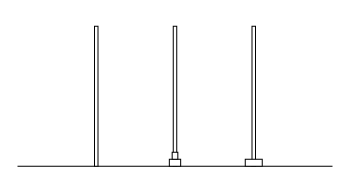

In [10]:
print("step " + str(step))
display(state_sequence[step])
step += 1

step 5


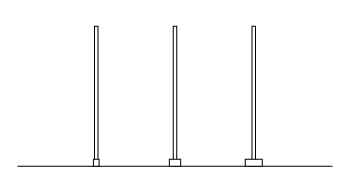

In [11]:
print("step " + str(step))
display(state_sequence[step])
step += 1

step 6


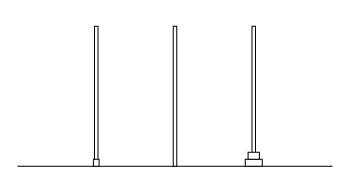

In [12]:
print("step " + str(step))
display(state_sequence[step])
step += 1

step 7


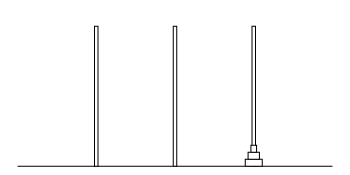

In [13]:
print("step " + str(step))
display(state_sequence[step])
step += 1

## Chosen application domain II - Blocks World

<img src='report_figures/blocks.png'>


## Chosen application domain II - Blocks World

We have defined the domain in Python and it contains a two operators:

- `pick(?what-block, ?from-object, ?to-object)`, which picks block `?what` from object `?from` (either a slot of the table or another block) 
- `put(?what-block, ?to-object)`, which puts block to object `?to` (also, either one position of the table or a block). 

Our planning framework can take care of static preconditions (no instantiations of operators for one block with itself).

We have also implemented a problem generator. The generator can create problems for any number of blocks and slots on the table. 

In [14]:
import planning

from IPython.display import display

import random

random.seed(42)

In [15]:
domain_name = "Blocks"
domain = planning.domains[domain_name]
problem = domain.generate_problem(3, 3)
print(domain)
print("Applicable actions in 1st state:")
l = list(filter(problem.init().can_apply, problem.operators()))
print("\n".join(map(str, l)))

Domain: Blocks
Types: {'slot': 'object', 'block': 'object'}
Operators:
  - pick(?what-block,?from-object):
    Pre: clear(?what), on(?what,?from), handempty()
    Add: clear(?from), holding(?what)
    Delete: clear(?what), on(?what,?from), handempty()
  - put(?what-block,?to-object):
    Pre: holding(?what), clear(?to)
    Add: clear(?what), on(?what,?to), handempty()
    Delete: holding(?what), clear(?to)
Applicable actions in 1st state:
pick(block01,block02)
pick(block03,slot3)


Init:


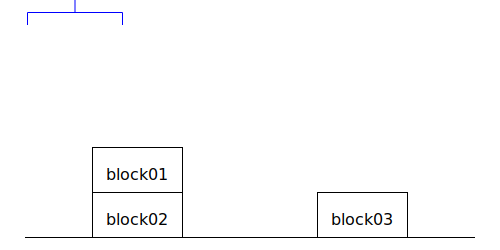

In [16]:
print("Init:")
display(problem.init())

Goal:


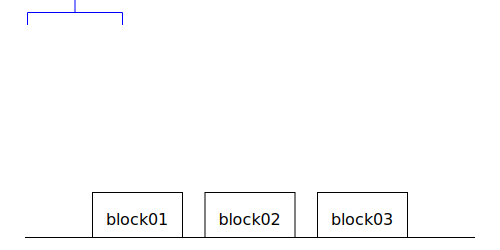

In [17]:
print("Goal:")
display(problem.goal())

In [18]:
bfs = planning.BreadthFirstSearch(problem, verbose=1, timeout=30.0, node_bound=None)
status = bfs()
if status == planning.search.FOUND:
    plan = bfs.plan()
    state_sequence = bfs.state_sequence()
    print("#Generated nodes: " + str(bfs.info()["generated"]))
    print("Plan:\n  " + "\n  ".join([str(op) for op in bfs.plan()]))

[0.002s] Plan found with 6 action(s)
#Generated nodes: 35
Plan:
  pick(block01,block02)
  put(block01,block03)
  pick(block02,slot1)
  put(block02,slot2)
  pick(block01,block03)
  put(block01,slot1)


In [19]:
step = 0
plan_lenght = len(state_sequence)

step 0


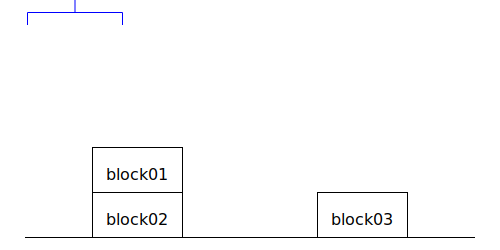

In [20]:
print("step " + str(step))
display(state_sequence[step])
step += 1

step 1


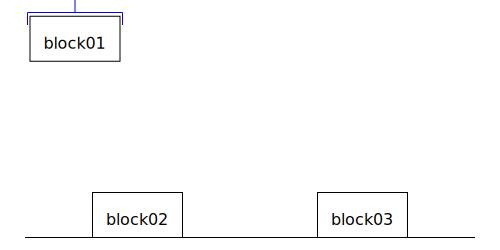

In [21]:
print("step " + str(step))
display(state_sequence[step])
step += 1

step 2


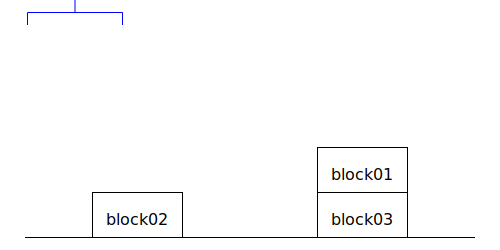

In [22]:
print("step " + str(step))
display(state_sequence[step])
step += 1

step 3


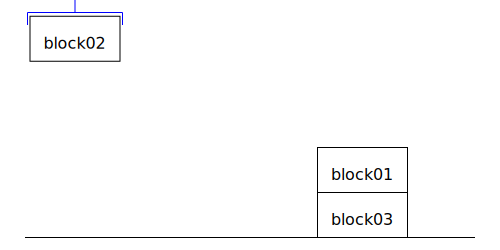

In [23]:
print("step " + str(step))
display(state_sequence[step])
step += 1

step 4


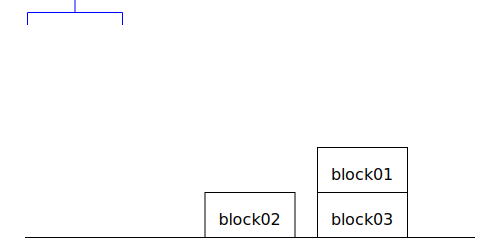

In [24]:
print("step " + str(step))
display(state_sequence[step])
step += 1

step 5


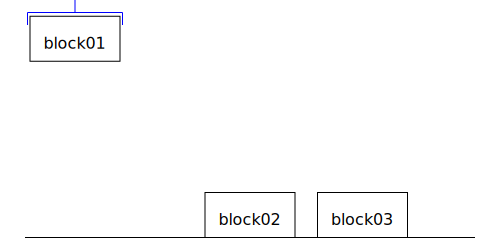

In [25]:
print("step " + str(step))
display(state_sequence[step])
step += 1

step 6


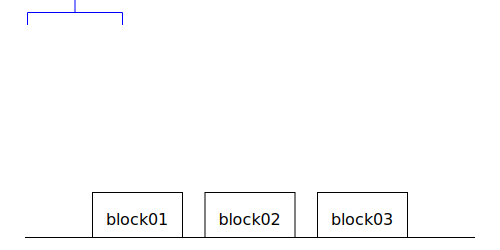

In [26]:
print("step " + str(step))
display(state_sequence[step])
step += 1

## Chosen application domain III - Elevators


Let's consider we have a building with several foors and people who want to go from one floor to another one. A lift, starting from one of the floors, has to satisfy all people petitions. The resctrictions are the following:

1. The lift can just move one floor each step
2. Just one person can get into/outo the lift each step

## Chosen application domain III - Elevators

We have defined the domain in Python and it contains a four operators: 

1. `board(?f-floor, ?p-passenger)`, which boards the passenger `?p` which is in the floor `?f`.
2. `depart(?f-floor, ?p-passenger)`, which departs the passenger `?p` in the floor `?f`. The passenger passes to be served.
3. `drive_up(?f1-floor, ?f2-floor)`, the lift goes up from floor `?f1` to floor `?f2`.
4. `drive_down(?f1-floor, ?f2-floor)`, the lift goes down from floor `?f1` to floor `?f2`.

Our planning framework can take care of static preconditions (no instantiations of operators for the same instance).

We have also implemented a problem generator. The generator can create problems for any number of people and floors. 

In [27]:
import planning

from IPython.display import display

import random

random.seed(1)

In [28]:
domain_name = "Elevator"
domain = planning.domains[domain_name]
problem = domain.generate_problem(3, 4)
print(domain)

print("Applicable actions in 1st state:")
print("\n".join(map(str, filter(problem.init().can_apply, problem.operators()))))

Domain: Elevator
Types: {'passenger': 'object', 'floor': 'object'}
Operators:
  - board(?f-floor,?p-passenger):
    Pre: lift-at(?f), origin(?p,?f)
    Add: boarded(?p)
    Delete: 
  - depart(?f-floor,?p-passenger):
    Pre: lift-at(?f), destin(?p,?f), boarded(?p)
    Add: served(?p)
    Delete: boarded(?p)
  - drive_down(?f1-floor,?f2-floor):
    Pre: lift-at(?f1), above(?f2,?f1)
    Add: lift-at(?f2)
    Delete: lift-at(?f1)
  - drive_up(?f1-floor,?f2-floor):
    Pre: lift-at(?f1), above(?f1,?f2)
    Add: lift-at(?f2)
    Delete: lift-at(?f1)
Applicable actions in 1st state:
drive_down(floor4,floor3)


Init:


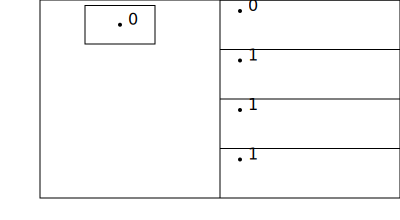

In [29]:
print("Init:")
display(problem.init())

In [30]:
bfs = planning.BreadthFirstSearch(problem, verbose=1, timeout=30.0, node_bound=None)
status = bfs()
if status == planning.search.FOUND:
    plan = bfs.plan()
    state_sequence = bfs.state_sequence()
    print("#Generated nodes: " + str(bfs.info()["generated"]))
    
    print("Plan:\n  " + "\n  ".join([str(op) for op in bfs.plan()]))

[0.043s] Plan found with 12 action(s)
#Generated nodes: 126
Plan:
  drive_down(floor4,floor3)
  board(floor3,passenger03)
  drive_down(floor3,floor2)
  board(floor2,passenger01)
  drive_down(floor2,floor1)
  board(floor1,passenger02)
  depart(floor1,passenger01)
  drive_up(floor1,floor2)
  drive_up(floor2,floor3)
  drive_up(floor3,floor4)
  depart(floor4,passenger02)
  depart(floor4,passenger03)


In [31]:
step = 0
plan_lenght = len(state_sequence)

step 0


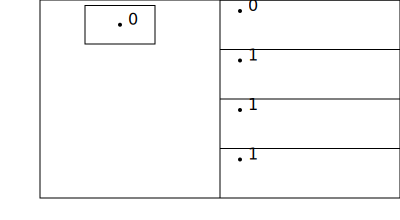

In [32]:
print("step " + str(step))
display(state_sequence[step])
step += 1

step 1


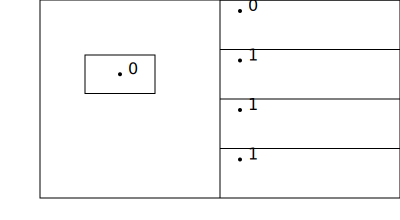

In [33]:
print("step " + str(step))
display(state_sequence[step])
step += 1

step 2


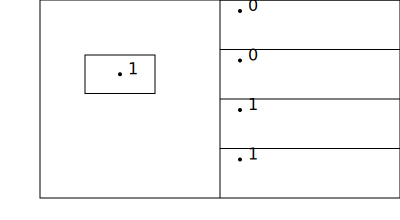

In [34]:
print("step " + str(step))
display(state_sequence[step])
step += 1

step 3


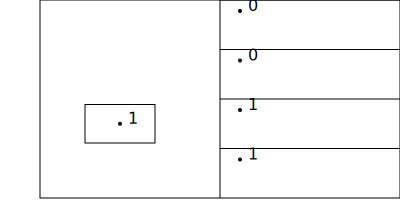

In [35]:
print("step " + str(step))
display(state_sequence[step])
step += 1

step 4


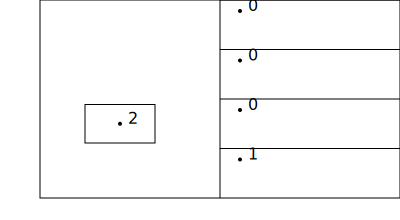

In [36]:
print("step " + str(step))
display(state_sequence[step])
step += 1

step 5


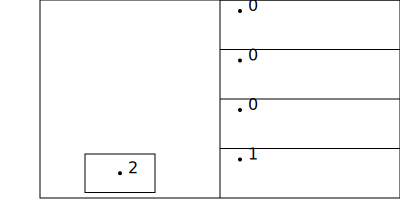

In [37]:
print("step " + str(step))
display(state_sequence[step])
step += 1

step 6


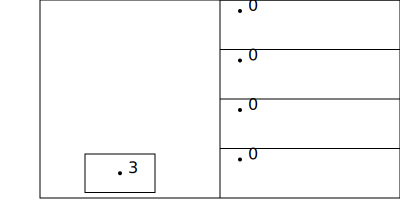

In [38]:
print("step " + str(step))
display(state_sequence[step])
step += 1

step 7


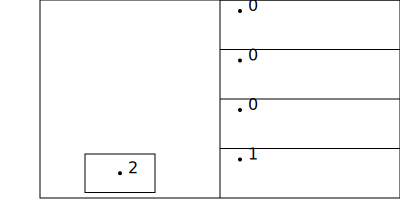

In [39]:
print("step " + str(step))
display(state_sequence[step])
step += 1

step 8


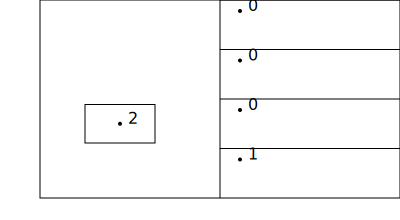

In [40]:
print("step " + str(step))
display(state_sequence[step])
step += 1

step 9


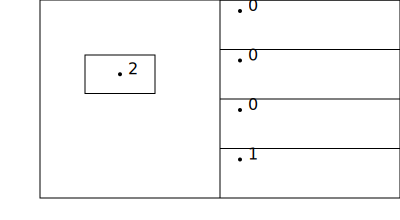

In [41]:
print("step " + str(step))
display(state_sequence[step])
step += 1

step 10


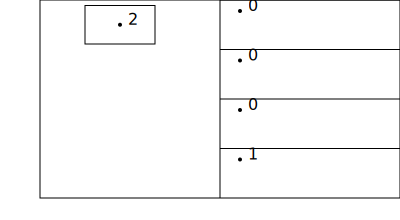

In [42]:
print("step " + str(step))
display(state_sequence[step])
step += 1

step 11


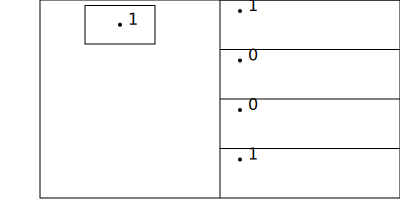

In [43]:
print("step " + str(step))
display(state_sequence[step])
step += 1

step 12


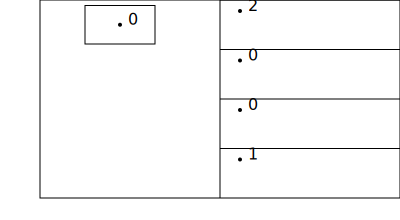

In [44]:
print("step " + str(step))
display(state_sequence[step])
step += 1

## Requirements: Users's perspective

Our system, **general** as it is, can be used in any sort of application in which is interesting the use of a planning system. In **any domain** in which a user has a problem which can be solved with planning techniques, our project is useful. Requirements will depend on the **specific use application**.

Target users (specialised people):

- Researchers
- Designers and developers from priver companies

Possible domains: robotics, industrial organization, assembly lines or applications related to the use of satellites.

## Requirements: Technical view

Our system is pretty general so we do not have specific requirements like maximum response time.

When designing our system we tried to address the following specific requirements:

1. The system should be **faster** than a conventional planner and expand **less nodes** when searching the solution.

2. The computed **heuristic** should be as **precise** as possible. 

3. The CBR system was thought to start learning with **simple problems** of the specific domain and continue doing so with **more difficult** and specific problems.

## Functional Architecture of the CBR engine Project

In this project we have designed a system of general purpose, so that the functional architecture is quite simple to be used. Just four different entities take part in our Functional Architecture: 


<img src='report_figures/functional_architecture.png'>


## Case Structure and Case Library Structure designed

Case Structure as a vector of Heuristics.

- Additive (add)

- Additive CEGAR (cegar) 

- Causal Graph (cg)

- Canonical PDB (cpdbs)

- FF (ff)

- Global Count (globalcount)

- Max Heuristic (hmax)

- Landmark Cut (lmcut)


Regarding the **Case Library Structure**, we have used *k-d tree*, which is useful for recover the sublinear time in the most similar cases, in our case, the vector of heuristics. The value of 'k' corresponds to the number of heuristics we use, eitght.

## Methods of every CBR cycle step

- **Retrieve:** K-Nearest Neighbors (KNN) algorithm. 

- **Reuse (Adaptation):** In our case we do not adapt the retrieved solution, of course, a more intelligent behaviour should be implemented in future work.

- **Revise:** We compare our solution to the solution given by the A* algorithm in the case of using just one heuristic, the additive. 

- **Retain (Learning):** All generated plans are learned.

## Testing

- Generation of several simple random problems for each domain (1000). 
- Solving each problem with a search algorithm that is guaranteed to solve the problem optimally. 
- Storing the heuristics computed by Fast Downward in a matrix (input attributes) and the length of the plan in a vector (output target). 
- Training/testing split and feed a KNN regressor with the train data. 
- Computing error on the test:
    * The RMS (Root Mean Square) error between the predictions and the targets
    * The ranking error. This is, we check all the pairs of test examples and see whether the order induced by the target differs from the order induced by the prediction.

## Results I

<img src='report_figures/Elevator_Results.png'>

## Results II

We have computed the error of the KNN regressor and represented it in the following table:

| Domain    | RMS error | Ranking error (KNN) | Ranking error ($h_{add}$) |
|----------:|----------:|--------------------:|----------------------------:|
| Hanoi     |      0.85 |               5.57% |                      13.73% |
| Blocks    |      1.00 |               2.00% |                      14.42% |
| Elevators |      0.70 |               3.62% |                       9.31% |

## Conclusions

- A KNN armed with a reasonably big training data set seems quite capable of obtaining a low regression error.

- Achieving a low RMS alone is not a strong enough guarantee for outperforming classical heuristic search in terms of expanded nodes. 

- No obvious way to optimize the induced order instead of the absolute value. This is a matter of further research.

## Future Work

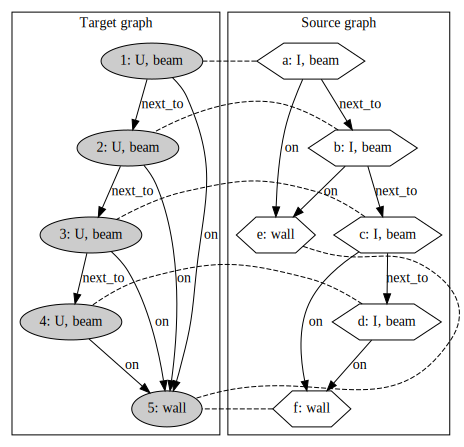

similarity: 72.73%
elapsed: 1.379s


In [45]:
from graphsim import Graph
from graphsim import graph_match_dot, default_f_score, default_g_cost
from graphsim import best_mapping, greedy_mapping, r_greedy_mapping
from IPython.core.display import display
from time import clock

def demo(graph1, graph2, method=best_mapping, f=default_f_score, g=default_g_cost, display_before=False):
    if display_before: display(graph_match_dot(graph1, graph2))
    start = clock()
    mapping, similarity = method(graph1, graph2, f, g)
    elapsed = clock() - start
    display(graph_match_dot(graph1, graph2, mapping))
    print("similarity: {:.02f}%\nelapsed: {:.03f}s".format(similarity*100, elapsed))
    
graph1 = Graph(('a', 'beam'), ('a', 'I'), ('b', 'beam'), ('b', 'I'), ('c', 'beam'),
               ('c', 'I'), ('d', 'beam'), ('d', 'I'), ('e', 'wall'), ('f', 'wall'),
               ('a', 'b', 'next_to'), ('b', 'c', 'next_to'), ('c', 'd', 'next_to'),
               ('a', 'e', 'on'), ('b', 'e', 'on'), ('c', 'f', 'on'), ('d', 'f', 'on'))

graph2 = Graph((1, 'beam'), (1, 'U'), (2, 'beam'), (2, 'U'), (3, 'beam'),
               (3, 'U'), (4, 'beam'), (4, 'U'), (5, 'wall'), (1, 2, 'next_to'),
               (2, 3, 'next_to'), (3, 4, 'next_to'), (1, 5, 'on'), (2, 5, 'on'),
               (3, 5, 'on'), (4, 5, 'on'))

demo(graph1, graph2)

# Thanks for your attention!